In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy, pickle

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')

from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import cost_functions as cost_functions
from neurolib.optimal_control import oc_wc


# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [2]:
points_bi = [
    [2.9, 2.1], [2.9, 2.5], [2.9, 2.9], [2.9, 3.3],
    [3.3, 2.5], [3.3, 2.9], [3.3, 3.3],
    [3.7, 2.9], [3.7, 3.3],
    [4.1, 3.3],
]

In [153]:
def gettarget(targetstate):
    target = np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]
    target[0,0,:] = targetstate[0]
    target[0,1,:] = targetstate[1]

    return target

def setinit(initstate):
    wc.params["exc_init"] = np.array([[ initstate[0] ]])
    wc.params["inh_init"] = np.array([[ initstate[1] ]])

def decrease_step_compute():

    for pow in [-4, -5]:

        wc_controlled.step = 10**pow
        wc_controlled.zero_step_encountered = False
        wc_controlled.optimize(200)

def increase_step_compute():

    for pow in [-2, -1, 0, 2, 4]:

        wc_controlled.step = 10**pow
        wc_controlled.zero_step_encountered = False
        wc_controlled.optimize(200*(3 + pow))

    return

def get_values(results_dict, ip, w):
    results_dict["control"][ip] = wc_controlled.control.copy()
    results_dict["state"][ip] = wc_controlled.get_xs().copy()
    results_dict["cost"][ip] = wc_controlled.cost_history[-1]

    wc_controlled.w_1D = 0.
    wc_controlled.simulate_forward()
    results_dict["precision_cost"][ip] = wc_controlled.compute_total_cost()
    wc_controlled.w_1D = w

    ce = np.zeros((results_dict["control"][ip].shape))
    ce[0,0,:] = results_dict["control"][ip][0,0,:]
    results_dict["L_cost"][ip][0] = cost_functions.energy_cost(ce, 1., dt)
    ci = np.zeros((results_dict["control"][ip].shape))
    ci[0,1,:] = results_dict["control"][ip][0,1,:]
    results_dict["L_cost"][ip][1] = cost_functions.energy_cost(ci, 1., dt)

    return

def getmodel(t, w, results_dict, i):
    wc_controlled = oc_wc.OcWc(wc, target=t, w_p=1, w_2=0., w_1D=w, print_array=[], precision_cost_interval=(int0,None), control_matrix=control_mat, precision_matrix=prec_mat)

    if type(results_dict["control"][i]) != type(None):
        wc_controlled.control = results_dict["control"][i].copy()
        wc_controlled.update_input()
    wc_controlled.model.run()    

    return wc_controlled


In [167]:
n_points = len(points_bi)
w_array = [0.25, 1., 4.]
none_array = [[None] * n_points, [None] * n_points, [None] * n_points ]
file_array = []
for i in range(len(points_bi)):
    file_array.append('w1_' + str(i+1) + '.png')

results_w1_du = dict([
    ('cost_type', 'w1'),
    ('point', [None] * n_points),
    ('d', [None] * n_points),
    ('u', [None] * n_points),
    ("cost", [None] * n_points),
    ("initial_cost", [None] * n_points),
    ("precision_cost", [None] * n_points),
    ("L_cost", [np.zeros((2))] * n_points),
    ("control", [None] * n_points),
    ("state", [None] * n_points),
    ("filename", file_array)
    ])

def save(results_dict):
    filehandler = open("w1_du.pickle","wb")
    pickle.dump(results_dict,filehandler)
    filehandler.close()

In [168]:
points_bi = [
    [2.9, 2.1], [2.9, 2.5], [2.9, 2.9], [2.9, 3.3],
    [3.3, 2.5], [3.3, 2.9], 
    [3.3, 3.3],
    [3.7, 2.9], [3.7, 3.3],
    [4.1, 3.3],
]

wc = WCModel()
wc.params.sigma_ou = 0.
dt = 0.1
wc.params.dt = dt
duration = 500.
wc.params["duration"] = duration

zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
bi_control = zero_input.copy()
bi_control[0,:500] = -5.
bi_control[0,2500:3000] = +5.

for i in range(len(points_bi)):

    p = points_bi[i]
    results_w1_du['point'][i] = p

    wc.params["exc_ext"] = bi_control + p[0]
    wc.params["inh_ext"] = zero_input + p[1]
    wc.run()

    results_w1_du['d'][i] = [wc.exc[0,2000], wc.inh[0,2000]]
    results_w1_du['u'][i] = [wc.exc[0,-1], wc.inh[0,-1]]

    #plt.plot(wc.exc[0,:])
    #plt.show()

In [169]:
int0 = 1800
w1 = 1.

control_mat = np.zeros( (wc.params.N, len(wc.state_vars)) )
control_mat[0,0] = 1.
control_mat[0,1] = 1.

prec_mat = np.zeros( (wc.params.N, len(wc.output_vars)) )
prec_mat[0,0] = 1.
prec_mat[0,1] = 1.

duration = 200.
wc.params["duration"] = duration
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)

for i in range(len(points_bi)):

    print("POINT ", i+1)

    #if results_w1_du["cost"][i] < 2.:
    #    continue

    p = points_bi[i]

    wc.params["exc_ext"] = zero_input + p[0]
    wc.params["inh_ext"] = zero_input + p[1]

    target = gettarget( results_w1_du['u'][i] )
    setinit( results_w1_du['d'][i] )

    if type(results_w1_du["control"][i]) != type(None):
        continue

    #results_w1_du["control"][i] = None
        
    wc_controlled = getmodel(target, w1, results_w1_du, i)

    wc_controlled.step = 1e-3
    wc_controlled.optimize(1)

    results_w1_du["initial_cost"][i] = wc_controlled.cost_history[0]

    wc_controlled.control[0,0,-300:-200] = 5.
    wc_controlled.update_input()

    wc_controlled.step = 1e-2
    wc_controlled.optimize(100)

    increase_step_compute()

    ce = wc_controlled.cost_history[-1]
    control_e = wc_controlled.control.copy()

    wc_controlled.control[0,0,:] = 0.
    wc_controlled.control[0,1,-300:-200] = -5.
    wc_controlled.update_input()

    wc_controlled.step = 1e-2
    wc_controlled.optimize(100)

    increase_step_compute()

    ci = wc_controlled.cost_history[-1]

    if ce <= ci:
        wc_controlled.control = control_e.copy()
        wc_controlled.update_input()

    wc_controlled.optimize(0)    
    get_values(results_w1_du, i, w1)    

    for k in range(10):
        c0 = np.zeros((wc_controlled.control.shape))
        c0[0,:,:-100] = wc_controlled.control[0,:,100:]
        wc_controlled.control = c0.copy()
        wc_controlled.update_input()

        wc_controlled.step = 10**(-(k))
        wc_controlled.step_factor *= 0.8
        wc_controlled.optimize(100)

        decrease_step_compute()

        if results_w1_du["cost"][i] > wc_controlled.cost_history[-1]:
            get_values(results_w1_du, i, w1)

    save(results_w1_du)

POINT  1
Compute control for a deterministic system
Cost in iteration 0: 2.4780218055998215
Converged in iteration 1 with cost 2.4780218055998215 because of step counter
Final cost : 2.4780218055998215
Compute control for a deterministic system
Cost in iteration 0: 15.811815347937504
Final cost : 14.811814645313165
Compute control for a deterministic system
Cost in iteration 0: 14.811814645313165
Final cost : 12.811812802220631
Compute control for a deterministic system
Cost in iteration 0: 12.811812802220631
Final cost : 1.3154772546187101
Compute control for a deterministic system
Cost in iteration 0: 1.3154772546187101
Final cost : 1.0032094831098088
Compute control for a deterministic system
Cost in iteration 0: 1.0032094831098088
Final cost : 1.0003603416119973
Compute control for a deterministic system
Cost in iteration 0: 1.0003603416119973
Converged in iteration 1 with cost 1.0003603416119973 because of step counter
Final cost : 1.0003603416119973
Compute control for a determin

POINT  1
0.9968192040843458 2.4780218055998215


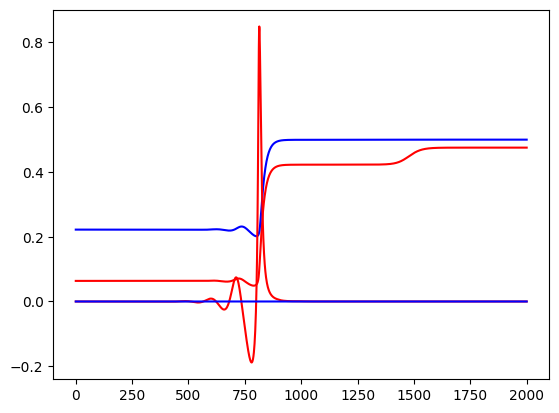

POINT  2
1.508749827631778 2.7238804909935936


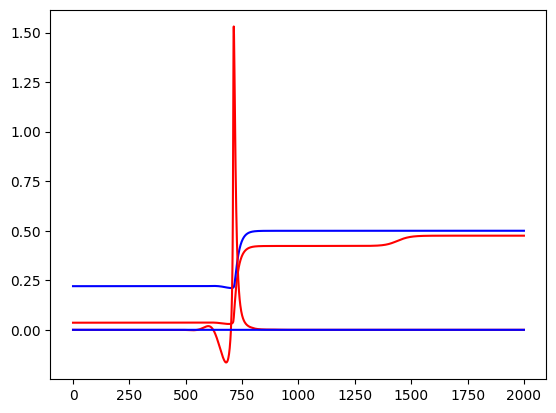

POINT  3
2.0705011877232047 2.794785708126736


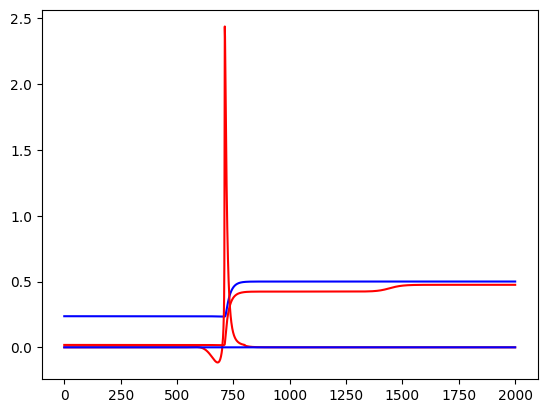

POINT  4
2.6480801808782304 2.7329776604176903


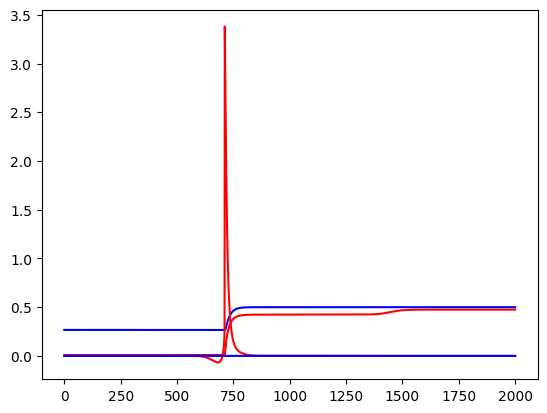

POINT  5
1.0645102237492141 2.5246808324957213


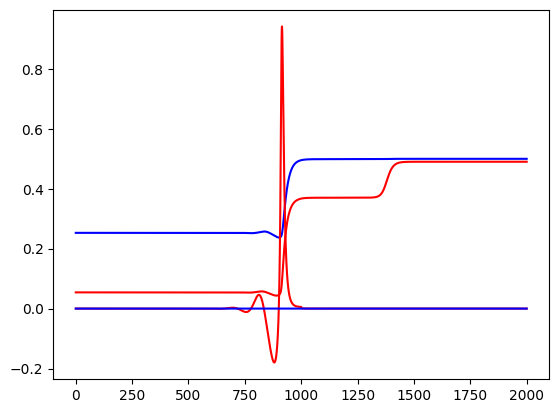

POINT  6
1.5832462888163061 2.7269764265375467


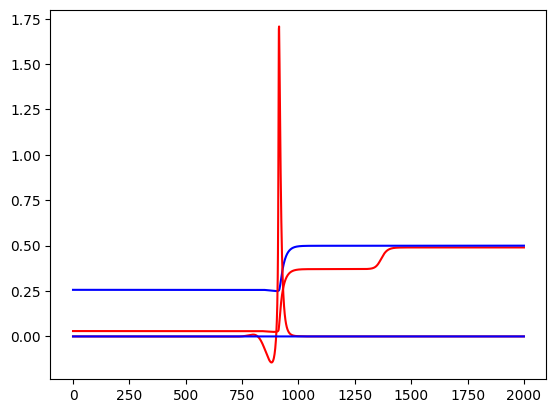

POINT  7
2.153077039067327 2.769577460088557


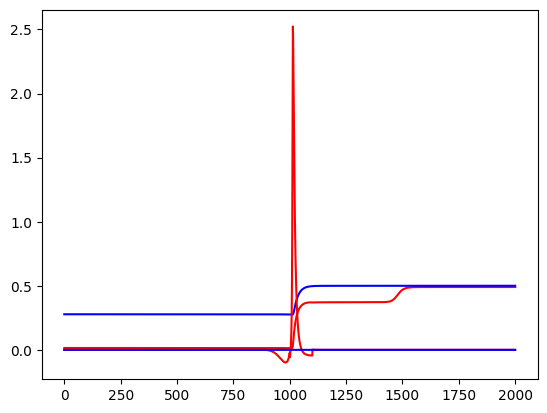

POINT  8
1.1469337490125022 2.493992239059809


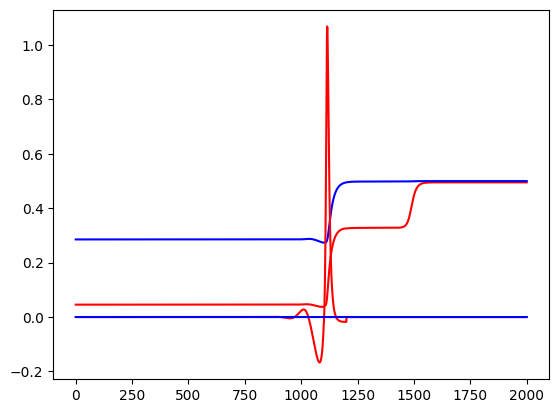

POINT  9
1.6721869735613468 2.653249494318241


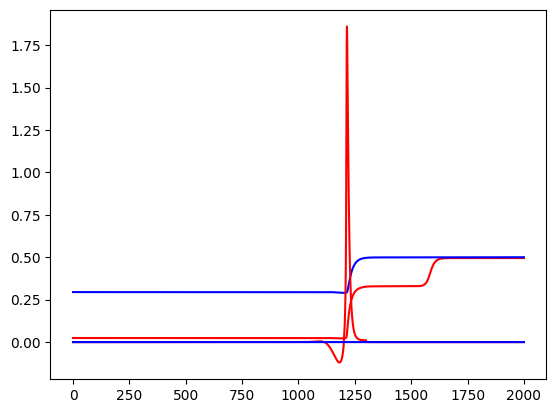

POINT  10
1.2218988855352835 2.4446766927506416


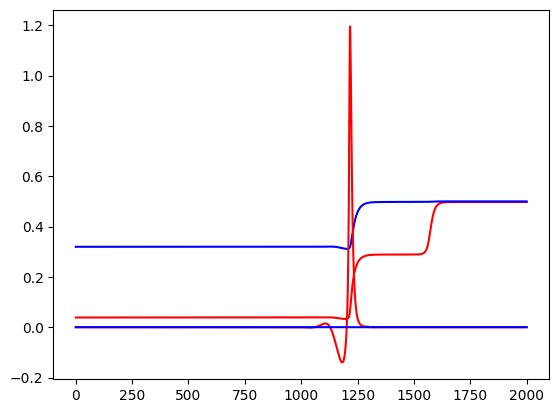

In [170]:
for i in range(len(points_bi)):
    print("POINT ", i+1)
    print(results_w1_du["cost"][i], results_w1_du["initial_cost"][i])
    plt.plot(results_w1_du["state"][i][0,0,:], color="red", linestyle='-')
    plt.plot(results_w1_du["state"][i][0,1,:], color="blue", linestyle='-')
    plt.plot(results_w1_du["control"][i][0,0,:], color="red")
    plt.plot(results_w1_du["control"][i][0,1,:], color="blue")
    plt.show()